# Meat Quality Classification
- Fresh
- Spoiled

In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

from glob import glob
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import cv2

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.style.use('seaborn-whitegrid')
sns.set_palette('Set2')

import tensorflow as tf

import os
print(os.listdir('../input/'))

import warnings
warnings.simplefilter('ignore')

from time import time, strftime, gmtime
start = time()
import datetime
print(str(datetime.datetime.now()))

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


['meat-quality-assessment-based-on-deep-learning']
2021-04-21 05:36:03.945801


In [2]:
base_dir = '../input/meat-quality-assessment-based-on-deep-learning/'
os.listdir(base_dir)

['Fresh', 'README.txt', 'license.txt', 'Spoiled']

In [3]:
fresh = glob(base_dir + 'Fresh/*.jpg')
spoiled = glob(base_dir + 'Spoiled/*.jpg')

print(f"Number of images in Fresh Category: {len(fresh)}")
print(f"Number of images in Spoiled Category: {len(spoiled)}")

Number of images in Fresh Category: 948
Number of images in Spoiled Category: 948


In [4]:
fresh[:5], spoiled[:5]

(['../input/meat-quality-assessment-based-on-deep-learning/Fresh/test_20171016_165121D.jpg',
  '../input/meat-quality-assessment-based-on-deep-learning/Fresh/test_20171016_203521D.jpg',
  '../input/meat-quality-assessment-based-on-deep-learning/Fresh/test_20171016_195721D.jpg',
  '../input/meat-quality-assessment-based-on-deep-learning/Fresh/test_20171017_113721D.jpg',
  '../input/meat-quality-assessment-based-on-deep-learning/Fresh/test_20171017_163721D.jpg'],
 ['../input/meat-quality-assessment-based-on-deep-learning/Spoiled/test_20171018_222121D.jpg',
  '../input/meat-quality-assessment-based-on-deep-learning/Spoiled/test_20171018_130121D.jpg',
  '../input/meat-quality-assessment-based-on-deep-learning/Spoiled/test_20171018_111521D.jpg',
  '../input/meat-quality-assessment-based-on-deep-learning/Spoiled/test_20171018_193521D.jpg',
  '../input/meat-quality-assessment-based-on-deep-learning/Spoiled/test_20171018_232321D.jpg'])

# Display few Images from Fresh Category

In [5]:
def display_images(paths, rows, cols, cat = None):
    fig, ax = plt.subplots(rows, cols, figsize = (16, 12))
    ax = ax.flatten()
    if cat == 'Fresh':
        c = 'green'
    else:
        c = 'red'
    for i, path in enumerate(image_paths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        ax[i].set_title(f"{cat} - {img.shape}", color = c)
        ax[i].imshow(img)
        ax[i].grid(False)
    plt.tight_layout()
    plt.show()

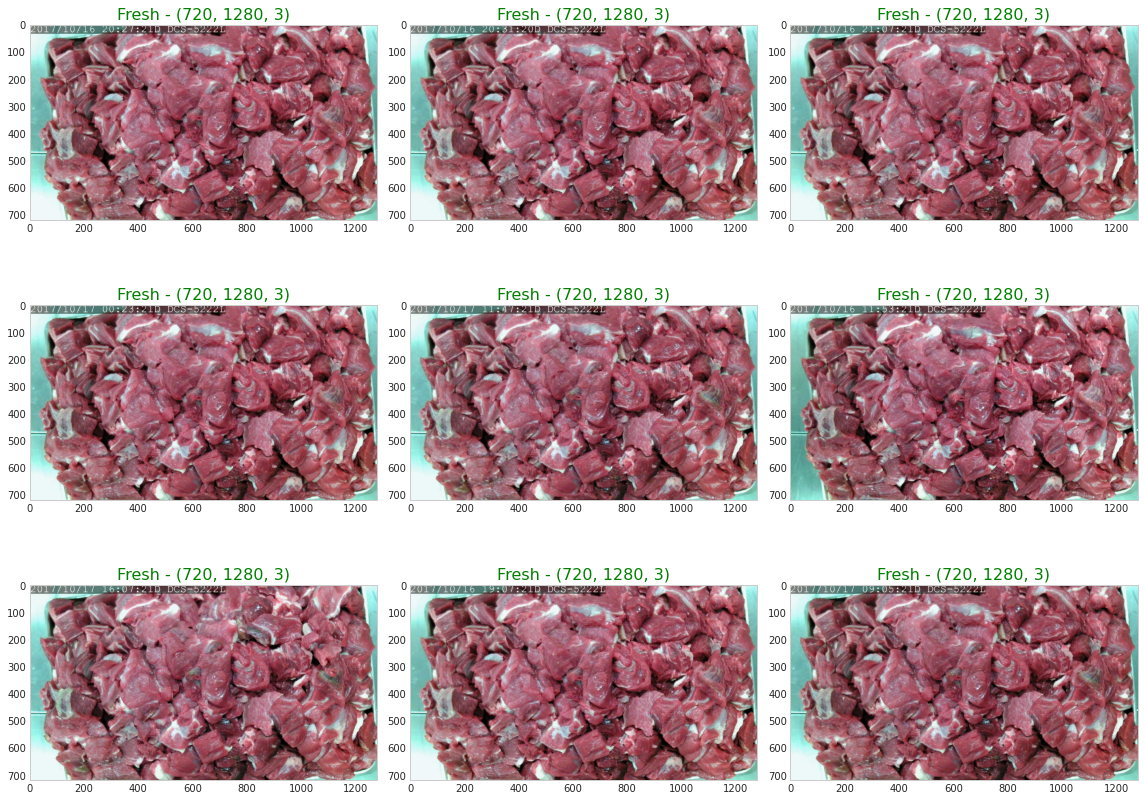

In [6]:
image_paths = np.random.choice(fresh, 9)
display_images(image_paths, 3, 3, 'Fresh')

# Display few Images from Spoiled Category

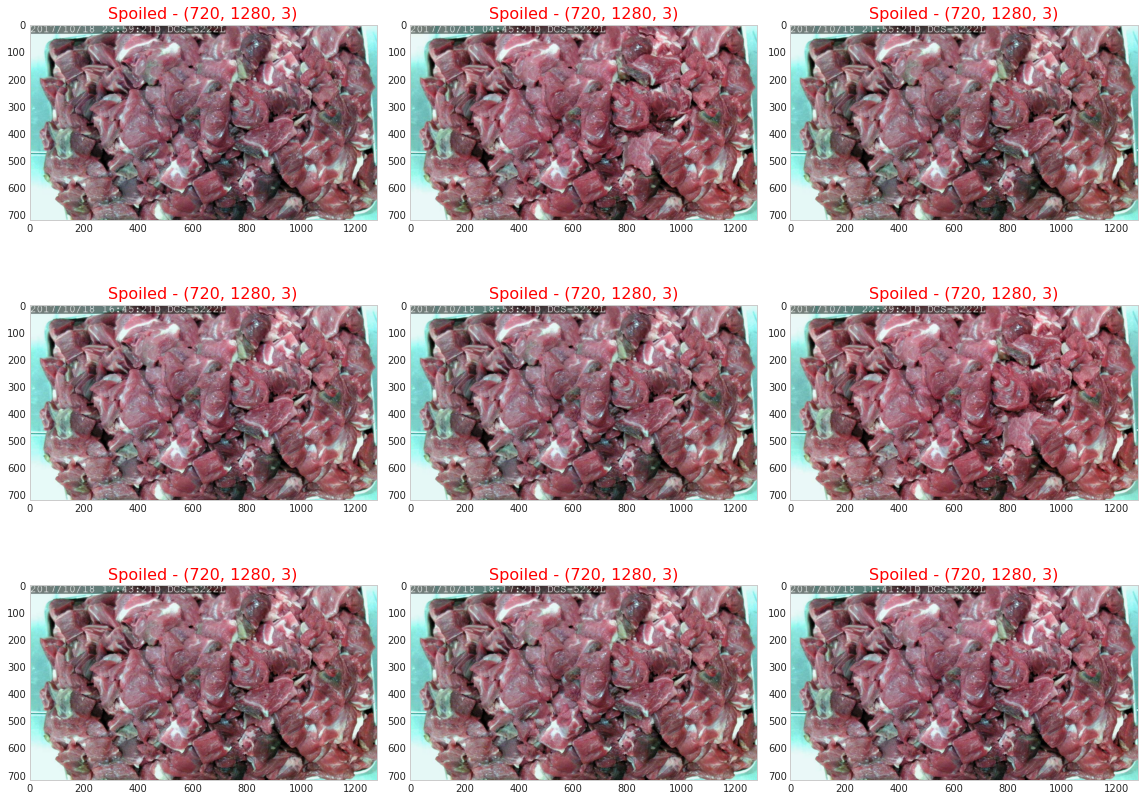

In [7]:
image_paths = np.random.choice(spoiled, 9)
display_images(image_paths, 3, 3, 'Spoiled')

- Images are of same shape: (720, 1280, 3)
- All these images are of same batch taken at different time intervals, I don't think a model will generalise well to other unseen images

__Make a Dataframe of image path and class__

In [8]:
df = pd.DataFrame(columns = ['image', 'target'])
df['image'] = fresh + spoiled
df['target'] = df['image'].apply(lambda x: 0 if 'Fresh' in x else 1)
df = df.sample(frac = 1).reset_index(drop = True)
labels = ['Fresh', 'Spoiled']
df.head()

image  \
0    ../input/meat-quality-assessment-based-on-deep-learning/Fresh/test_20171017_171921D.jpg   
1    ../input/meat-quality-assessment-based-on-deep-learning/Fresh/test_20171016_175721D.jpg   
2  ../input/meat-quality-assessment-based-on-deep-learning/Spoiled/test_20171019_023921D.jpg   
3    ../input/meat-quality-assessment-based-on-deep-learning/Fresh/test_20171016_153721D.jpg   
4    ../input/meat-quality-assessment-based-on-deep-learning/Fresh/test_20171017_172321D.jpg   

   target  
0       0  
1       0  
2       1  
3       0  
4       0

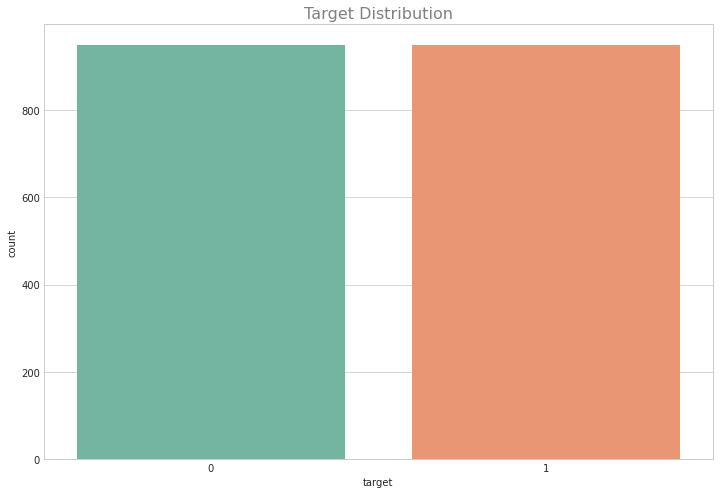

In [9]:
plt.title('Target Distribution', color = 'grey')
sns.countplot(data = df, x = 'target');

- Classes are balanced

In [10]:
print(tf.__version__)
import tensorflow.keras.layers as L
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

import math

2.4.1


In [11]:
dim = 256
seed = 2021
EPOCHS = 30

In [12]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print(BATCH_SIZE)
AUTO = tf.data.experimental.AUTOTUNE

REPLICAS:  1
16


__Helper Function to display training plots__

In [13]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot % 10 == 1: # set up the subplots on the first call
        plt.subplots(figsize = (10, 10), facecolor = '#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    #ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

__DenseNet121 Model__

In [14]:
from tensorflow.keras.applications.densenet import DenseNet121

In [15]:
with strategy.scope():
    model = tf.keras.Sequential([
        DenseNet121(
            input_shape = (dim, dim, 3),
            weights = 'imagenet',
            include_top = False),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation = 'elu', kernel_regularizer = regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation = 'elu', kernel_regularizer = regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(len(labels), activation = 'sigmoid')
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(0.001),
        loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
        metrics = ['accuracy']
                )
    model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________

__Split dataset into traina and valid sets__

In [16]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)
print(train_df.shape, valid_df.shape)

(1516, 2) (380, 2)


__We use Image augmentation__
- To increase the train size 
- To prevent overfitting, which is likely given the limited number of samples

In [17]:
def decode_image(filename, label = None, image_size = (dim, dim)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels = 3)
    image = tf.cast(image, tf.float32)
    image /= 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, tf.one_hot(label, depth = len(labels))

def data_augment(image, label = None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, lower = 0.3, upper = 0.9)
    
    if label is None:
        return image
    else:
        return image, label

In [18]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_df['image'], train_df['target']))
    .map(decode_image, num_parallel_calls = AUTO)
    #.map(data_augment, num_parallel_calls = AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_df['image'], valid_df['target']))
    .map(decode_image, num_parallel_calls = AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [19]:
for t, l in train_dataset.take(1):
    print(t.numpy().shape, l.numpy().shape)
    break

(16, 256, 256, 3) (16, 2)


In [20]:
def plot_dataset(dataset, row, col):
    for (img, lbls) in dataset.take(1):
        for i in range(row * col):
            ax = plt.subplot(row, col, i + 1)
            plt.imshow(img[i].numpy())
            if labels[np.argmax(lbls[i].numpy())] == 'Fresh':
                c = 'green'
            else:
                c = 'red'
            plt.title(labels[np.argmax(lbls[i].numpy())], color = c)
            plt.axis('off')
            plt.grid(False)
        plt.show()

__Train Dataset Images without Augmentation__

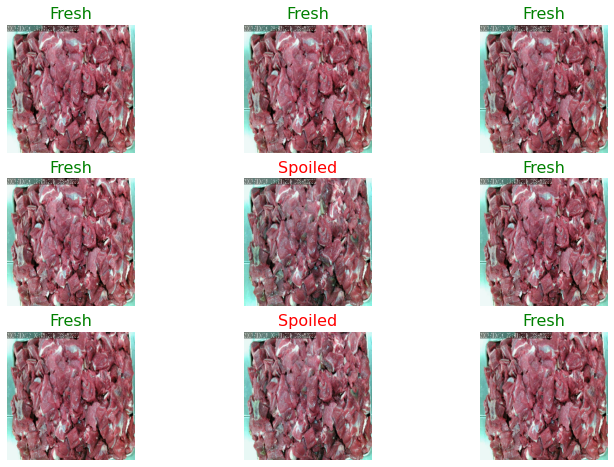

In [21]:
plot_dataset(train_dataset, 3, 3)

__Define Callback lists__

In [22]:
check = tf.keras.callbacks.ModelCheckpoint('./meat_model.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 4, verbose = 1)
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", patience = 3, factor = 0.1, mode = 'min', verbose = 1)

callback_list = [check, early]

steps_per_epoch = len(train_df) // BATCH_SIZE

In [23]:
history = model.fit(
                    train_dataset, 
                    epochs = 5,
                    verbose = 1,
                    callbacks = callback_list,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = valid_dataset
            )

Epoch 1/5
94/94 [==============================] - 45s 284ms/step - loss: 1.1136 - accuracy: 0.8931 - val_loss: 17.2950 - val_accuracy: 0.5079
Epoch 2/5
94/94 [==============================] - 18s 197ms/step - loss: 0.6287 - accuracy: 0.9908 - val_loss: 12.5727 - val_accuracy: 0.5079
Epoch 3/5
94/94 [==============================] - 18s 195ms/step - loss: 0.4954 - accuracy: 0.9932 - val_loss: 2.8338 - val_accuracy: 0.5921
Epoch 4/5
94/94 [==============================] - 18s 187ms/step - loss: 0.4026 - accuracy: 0.9910 - val_loss: 191.6312 - val_accuracy: 0.5079
Epoch 5/5
94/94 [==============================] - 18s 190ms/step - loss: 0.3059 - accuracy: 0.9939 - val_loss: 0.5089 - val_accuracy: 0.8579


In [24]:
print('Evaluate Model....')
ev = model.evaluate(valid_dataset, return_dict = True)
print(ev)

Evaluate Model....
24/24 [==============================] - 1s 38ms/step - loss: 0.5089 - accuracy: 0.8579
{'loss': 0.5089367628097534, 'accuracy': 0.8578947186470032}


In [25]:
del model, train_dataset, valid_dataset
gc.collect()

594

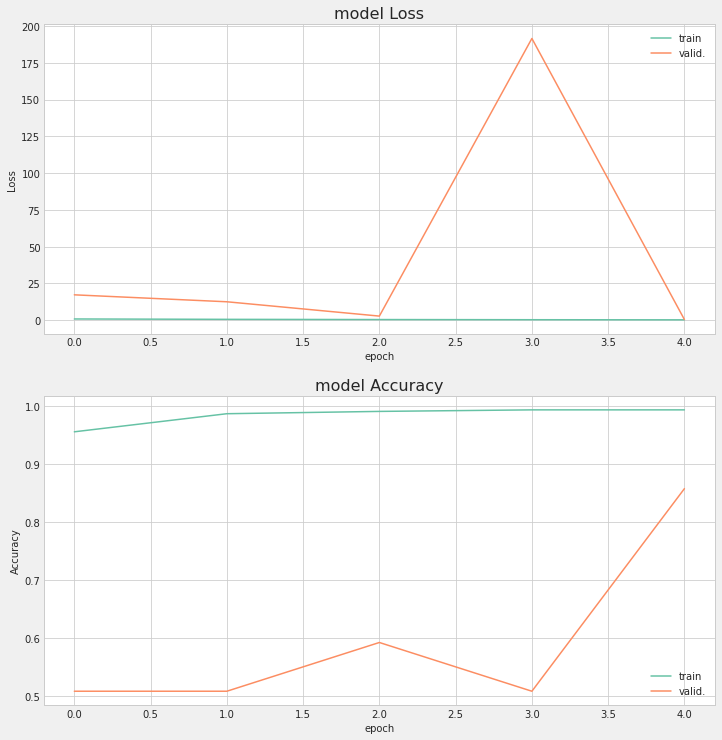

In [26]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'Loss', 211)
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'Accuracy', 212)

__Methods to prevent Overfitting__

- Our Model is clearly overfitting, the reason being few sample size.
- We will try to prevent overfitting with image augmentation as well as Learning Rate Scheduler
- We also change the metrics to BinaryCrossEntropy
- Doing this should help our model

In [27]:
with strategy.scope():
    model = tf.keras.Sequential([
        DenseNet121(
            input_shape = (dim, dim, 3),
            weights = 'imagenet',
            include_top = False),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation = 'elu', kernel_regularizer = regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation = 'elu', kernel_regularizer = regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(len(labels), activation = 'sigmoid')
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(0.001),
        loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
        metrics = [tf.keras.losses.BinaryCrossentropy(from_logits = True, 
                                                      name = 'BCE'), 'accuracy']
                )
    model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [28]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_df['image'], train_df['target']))
    .map(decode_image, num_parallel_calls = AUTO)
    .map(data_augment, num_parallel_calls = AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_df['image'], valid_df['target']))
    .map(decode_image, num_parallel_calls = AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

__Train Dataset Images with Augmentation__

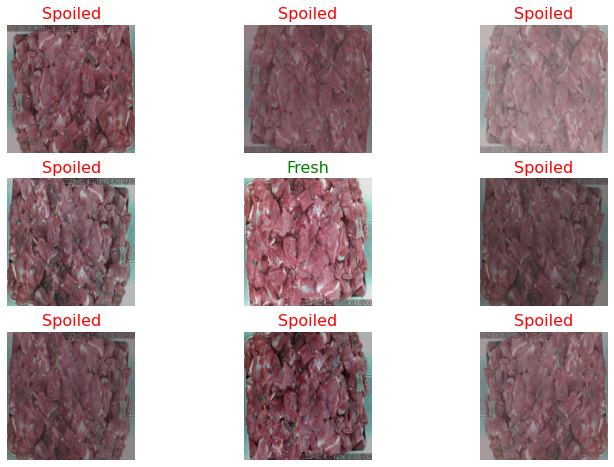

In [29]:
plot_dataset(train_dataset, 3, 3)

Learning rate schedule: 1e-08 to 0.00027 to 9.13e-07


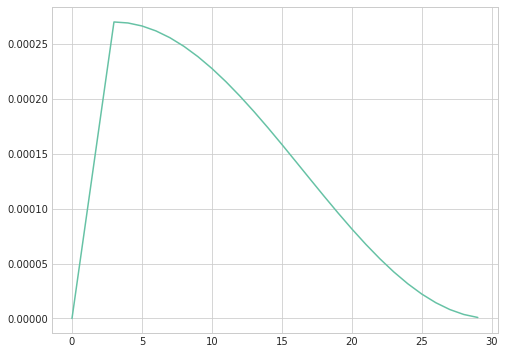

In [30]:
# Code Credits : https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop

LR_START = 1e-8
LR_MAX = 3e-5 * 9
LR_MIN = 1e-8
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

plt.figure(figsize = (8, 6))
rng = [i for i in range(25 if EPOCHS < EPOCHS else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [31]:
check = tf.keras.callbacks.ModelCheckpoint('./meat_det_model_.h5', monitor = 'val_binary_crossentropy', mode = 'min', save_best_only = True)
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_binary_crossentropy', mode = 'min', patience = 4, verbose = 1)
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_binary_crossentropy", patience = 3, factor = 0.1, mode = 'min', verbose = 1)

callback_list = [check, early]

steps_per_epoch = len(train_df) // BATCH_SIZE

In [32]:
history = model.fit(
                    train_dataset, 
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = callback_list,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = valid_dataset
            )

Epoch 1/30
94/94 [==============================] - 39s 253ms/step - loss: 1.3142 - BCE: 0.4618 - accuracy: 0.8397 - val_loss: 1.3114 - val_BCE: 0.6610 - val_accuracy: 0.8526
Epoch 2/30
94/94 [==============================] - 19s 202ms/step - loss: 0.8284 - BCE: 0.2021 - accuracy: 0.9366 - val_loss: 5.0070 - val_BCE: 4.4433 - val_accuracy: 0.6895
Epoch 3/30
94/94 [==============================] - 20s 210ms/step - loss: 0.6973 - BCE: 0.1609 - accuracy: 0.9359 - val_loss: 0.5370 - val_BCE: 0.0638 - val_accuracy: 0.9605
Epoch 4/30
94/94 [==============================] - 19s 200ms/step - loss: 0.5742 - BCE: 0.1211 - accuracy: 0.9573 - val_loss: 0.7349 - val_BCE: 0.3382 - val_accuracy: 0.8474
Epoch 5/30
94/94 [==============================] - 19s 199ms/step - loss: 0.4822 - BCE: 0.1034 - accuracy: 0.9550 - val_loss: 0.4698 - val_BCE: 0.1391 - val_accuracy: 0.9553
Epoch 6/30
94/94 [==============================] - 19s 198ms/step - loss: 0.4044 - BCE: 0.0906 - accuracy: 0.9592 - val_loss

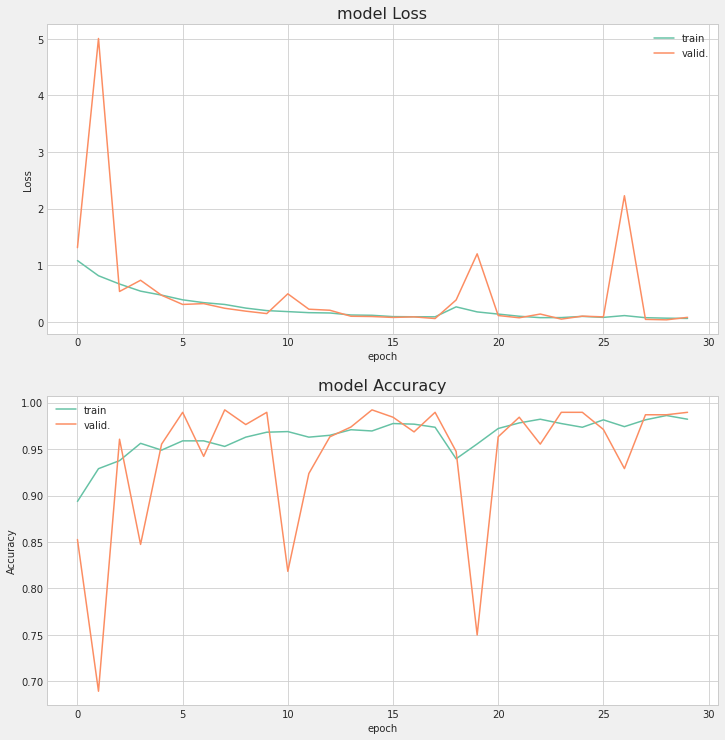

In [33]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'Loss', 211)
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'Accuracy', 212)

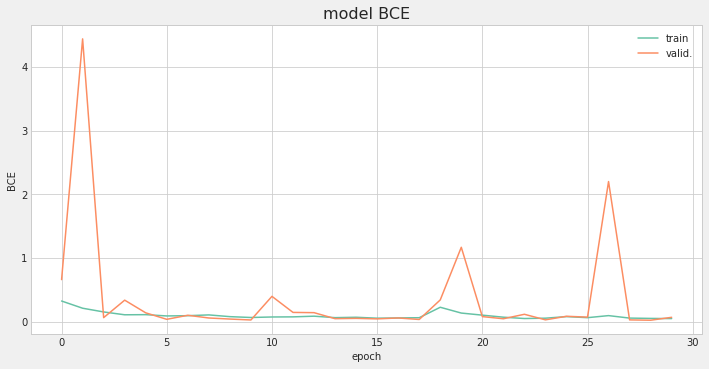

In [34]:
display_training_curves(
    history.history['BCE'], 
    history.history['val_BCE'], 
    'BCE', 211)

In [35]:
print('Evaluate Model....')
ev = model.evaluate(valid_dataset, return_dict = True)
print(ev)

Evaluate Model....
24/24 [==============================] - 1s 38ms/step - loss: 0.0798 - BCE: 0.0688 - accuracy: 0.9895
{'loss': 0.07981797307729721, 'BCE': 0.06875515729188919, 'accuracy': 0.9894737005233765}


In [36]:
preds = model.predict(valid_dataset, verbose = 1)
preds[:5]

24/24 [==============================] - 2s 37ms/step


array([[1.5195781e-04, 9.9989462e-01],
       [8.4844854e-05, 9.9994314e-01],
       [9.9979411e-04, 9.9921727e-01],
       [9.2587388e-01, 7.1939468e-02],
       [3.7385995e-04, 9.9972516e-01]], dtype=float32)

In [37]:
ytrue = valid_df['target'].values
ypred = np.argmax(preds, axis = 1)
ytrue[:5], ypred[:5]

(array([1, 1, 1, 0, 1]), array([1, 1, 1, 0, 1]))

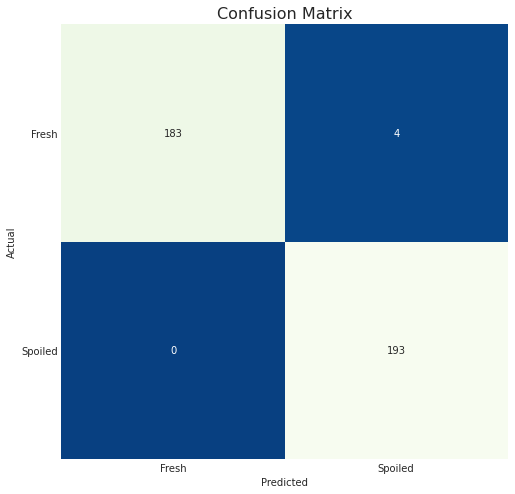

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

c_mat = confusion_matrix(ytrue, ypred)
c_report = classification_report(ytrue, ypred, target_names = labels)

plt.figure(figsize = (8, 8))
sns.heatmap(c_mat, annot = True, vmin = 0, fmt = 'g', cmap = 'GnBu_r', cbar = False)       
plt.xticks(np.arange(len(labels)) + .5, labels, rotation = 0)
plt.yticks(np.arange(len(labels))+.5, labels, rotation = 0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()    

In [39]:
print(c_report)

              precision    recall  f1-score   support

       Fresh       1.00      0.98      0.99       187
     Spoiled       0.98      1.00      0.99       193

    accuracy                           0.99       380
   macro avg       0.99      0.99      0.99       380
weighted avg       0.99      0.99      0.99       380



In [40]:
vdf = valid_df.reset_index(drop = True)
vdf.head(5)

image  \
0  ../input/meat-quality-assessment-based-on-deep-learning/Spoiled/test_20171018_000121D.jpg   
1  ../input/meat-quality-assessment-based-on-deep-learning/Spoiled/test_20171018_025721D.jpg   
2  ../input/meat-quality-assessment-based-on-deep-learning/Spoiled/test_20171018_142921D.jpg   
3    ../input/meat-quality-assessment-based-on-deep-learning/Fresh/test_20171016_224521D.jpg   
4  ../input/meat-quality-assessment-based-on-deep-learning/Spoiled/test_20171018_231521D.jpg   

   target  
0       1  
1       1  
2       1  
3       0  
4       1

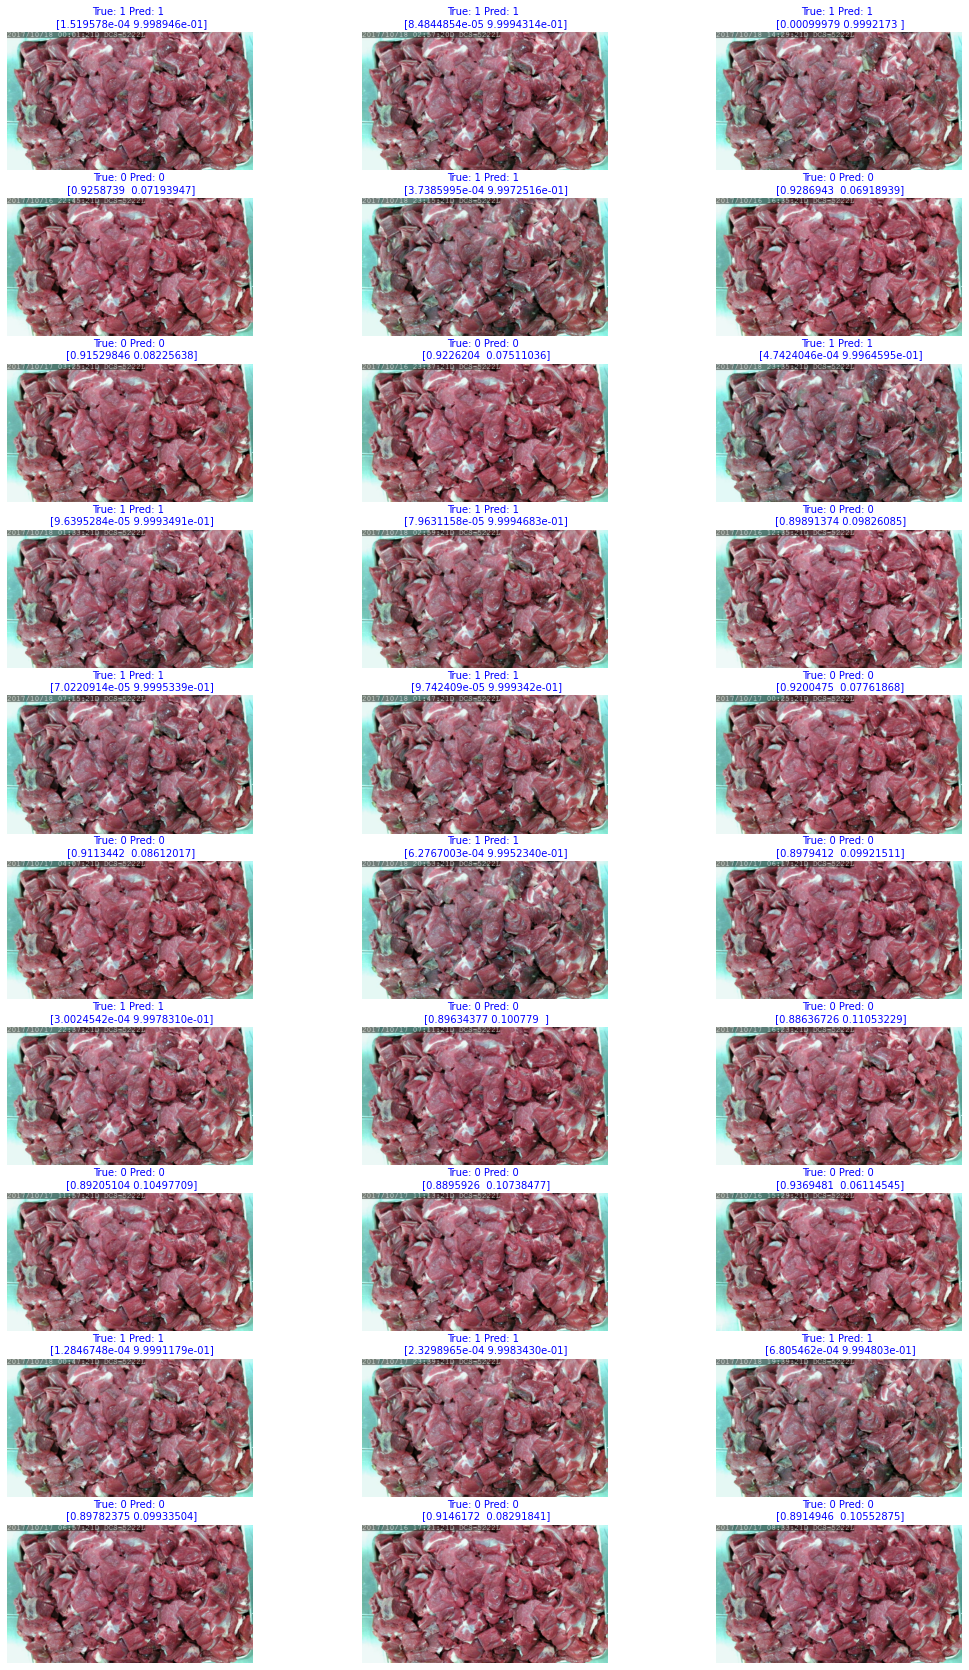

In [41]:
f, ax = plt.subplots(10, 3, figsize = (18, 30))

for idx, p in enumerate(ax.flatten()):
    bits = tf.io.read_file(vdf['image'][idx])
    image = tf.image.decode_jpeg(bits, channels = 3)
    p.imshow(image.numpy())
    if vdf['target'][idx] == ypred[idx]:
        c = 'blue'
    else:
        c = 'red'
    p.set_title(f"True: {vdf['target'][idx]} Pred: {ypred[idx]} \n {preds[idx]}", color = c, fontsize = 10)
    p.grid(False)
    p.axis('off')
plt.show()

In [42]:
finish = time()
print(strftime("%H:%M:%S", gmtime(finish - start)))

00:12:59
